In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, filtfilt

import math 
import json
import datetime
import calendar
import random

from scipy.stats import linregress, kurtosis, skew
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; } .CodeMirror pre {font-size: 9pt;}</style>"))

In [ ]:
rec_start_times = [1676149654828]  #[1657493585000, 1657507631000, 1657509660000, 1657522125000, 1657523495000, 1657646447000, 1657834205000, 1658079100000, 1657887659000, 1657870678000, 1657893978000, 1657862388000, 1657861308000, 1657529552000, 1657510592000, 1657831174000, 1657295717000, 1657521140000, 1657530461000, 1657536238000, 1657644994000]
rec_end_times  =  [1676149717828]  #[1657494185000, 1657508231000, 1657510260000, 1657522725000, 1657524095000, 1657647048000, 1657834806000, 1658079700000, 1657888260000, 1657871279000, 1657894579000, 1657862988000, 1657861909000, 1657530152000, 1657511192000, 1657831775000, 1657296317000, 1657521740000, 1657531061000, 1657536840000, 1657645595000]
nrecs = len(rec_start_times)
print(nrecs)
nrounds = 3
trial_len = 30000 #[20000, 21000, 20000]
sample_interval = 20

1


In [ ]:
recs = []
re_recs = []

for i in range(nrecs):
  df = pd.read_csv('./'+str(rec_start_times[i])+'.'+str(rec_end_times[i])+'.csv')
  df = df.drop_duplicates(subset=['timestamp'])
  recs.append(df)

  # create resampled dataframe rdf
  df['datetime'] = pd.to_datetime(df.timestamp, unit='ms')
  df.set_index('datetime', inplace=True)
  # display(df)

  rdf = pd.concat([df, df.asfreq('1ms')]).sort_index()
  rdf = rdf[~rdf.index.duplicated(keep='first')]
  rdf.interpolate(method='linear', axis=0, inplace=True)
  
  rdf.drop(rdf[(rdf.timestamp < rec_start_times[i]-10000) | (rdf.timestamp > rec_end_times[i])].index, inplace=True)
  rdf.drop(rdf[rdf.timestamp%sample_interval != 0].index, inplace=True)
  rdf.timestamp -= rec_start_times[i]
  rdf.hbo *= 10**13
  rdf.hbr *= 10**13
  rdf.hbt *= 10**13
  
  # display(rdf)
  re_recs.append(rdf)
  # print(rdf.shape)

FileNotFoundError: ignored

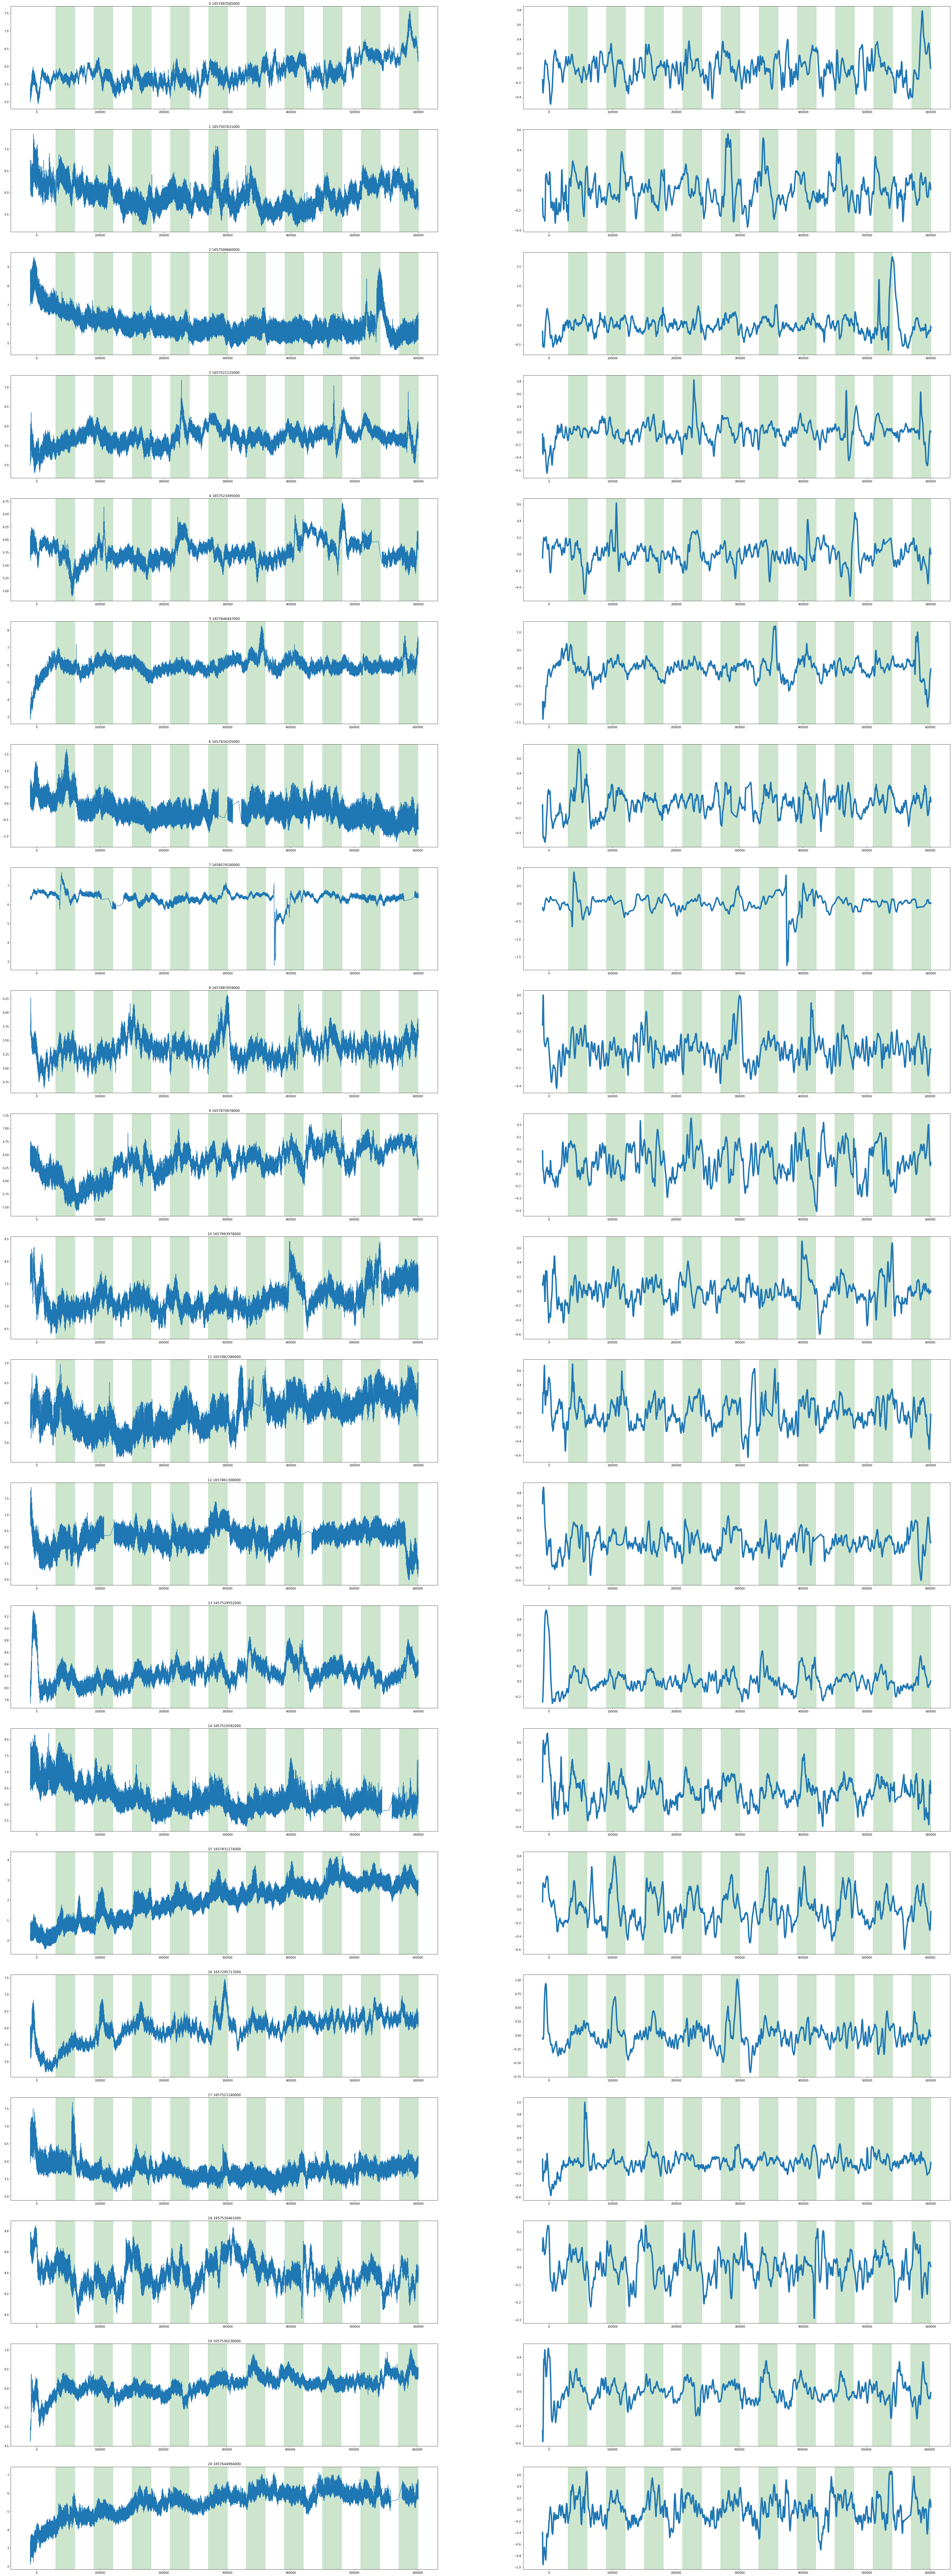

In [ ]:
pd.options.mode.chained_assignment = None
def filter(data, lowcut, highcut):
  fs = 50 # 50 Hz  (20ms intervals)
  order = 2

  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band') 
  y = filtfilt(b, a, data)
  return y

def filter_df(df, lowcut, highcut):
  df['hbo_filt'] = filter(df['hbo'], lowcut, highcut) 
  df['hbr_filt'] = filter(df['hbr'], lowcut, highcut) 
  df['hbt_filt'] = filter(df['hbt'], lowcut, highcut) 
  
  df['740nm10mm_filt'] = filter(df['740nm10mm'], lowcut, highcut) 
  df['740nm27mm_filt'] = filter(df['740nm27mm'], lowcut, highcut) 

  df['850nm10mm_filt'] = filter(df['850nm10mm'], lowcut, highcut) 
  df['850nm27mm_filt'] = filter(df['850nm27mm'], lowcut, highcut) 

  df['940nm10mm_filt'] = filter(df['940nm10mm'], lowcut, highcut) 
  df['940nm27mm_filt'] = filter(df['940nm27mm'], lowcut, highcut) 

  return(df)

fig, ax = plt.subplots(nrecs,2,figsize=(60, nrecs*8))
math_trials = []
rest_trials = []

for i in range(nrecs):
  lines = list(range(2*nrounds))
  lines = [l*trial_len for l in lines]

  rdf = filter_df(re_recs[i], 0.01, 0.5)

  for j in range(nrounds):
    math_df = rdf[(rdf.timestamp > -10000 + 2*trial_len*j) & (rdf.timestamp < 2*trial_len*j + trial_len)]
    rest_df = rdf[(rdf.timestamp > -10000 + 2*trial_len*j + trial_len) & (rdf.timestamp < 2*trial_len*j + 2*trial_len)]

    math_df.reset_index(drop=True, inplace=True)
    rest_df.reset_index(drop=True, inplace=True)

    math_trials.append(math_df)
    rest_trials.append(rest_df)
  
  ax[i,0].set_title(str(i) + " " + str(rec_start_times[i]))
  ax[i,0].plot(rdf.timestamp, rdf['hbo'])
  # ax[i,0].vlines(lines[::2], rdf['hbo'].min(), rdf['hbo'].max(), linestyles='dashed', colors='green', linewidth=3)
  # ax[i,0].vlines(lines[1::2], rdf['hbo'].min(), rdf['hbo'].max(), linestyles='dashed', colors='red', linewidth=3)

  ax[i,1].plot(rdf.timestamp, rdf['hbo_filt'], linewidth=5)
  # ax[i,1].vlines(lines[::2], rdf['hbo_filt'].min(), rdf['hbo_filt'].max(), linestyles='dashed', colors='green', linewidth=3)
  # ax[i,1].vlines(lines[1::2], rdf['hbo_filt'].min(), rdf['hbo_filt'].max(), linestyles='dashed', colors='red', linewidth=3)


  for n in range(10):
    ax[i,0].axvspan(60000*n+30000, 60000*n+60000, color='green', alpha=0.2)
    ax[i,1].axvspan(60000*n+30000, 60000*n+60000, color='green', alpha=0.2)

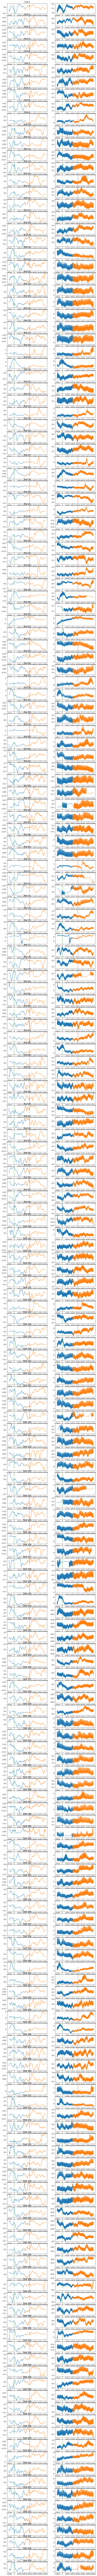

In [ ]:
fig, ax = plt.subplots(len(math_trials),2,figsize=(10, 300))

math_hbo_avg = np.zeros(len(math_trials[0]['hbo']))
rest_hbo_avg = np.zeros(len(rest_trials[0]['hbo']))

for i in range(len(math_trials)):
  math_trials[i]['timestamp'] = math_trials[i]['timestamp'] - math_trials[i]['timestamp'][0] - 10000
  rest_trials[i]['timestamp'] = rest_trials[i]['timestamp'] - rest_trials[i]['timestamp'][0] - 10000

  ax[i,0].set_title("Trial "+str(i))
  ax[i,0].plot(math_trials[i]['timestamp'], math_trials[i]['hbo_filt'])
  ax[i,0].vlines([0], math_trials[i]['hbo_filt'].min(), math_trials[i]['hbo_filt'].max(), linestyles='dashed', colors='green')
  
  ax[i,0].plot(rest_trials[i]['timestamp']+trial_len, rest_trials[i]['hbo_filt'])
  ax[i,0].vlines([trial_len], rest_trials[i]['hbo_filt'].min(), rest_trials[i]['hbo_filt'].max(), linestyles='dashed', colors='red')

  ax[i,1].plot(math_trials[i]['timestamp'], math_trials[i]['hbo'])
  ax[i,1].vlines([0], math_trials[i]['hbo'].min(), math_trials[i]['hbo'].max(), linestyles='dashed', colors='green')
  
  ax[i,1].plot(rest_trials[i]['timestamp']+trial_len, rest_trials[i]['hbo'])
  ax[i,1].vlines([trial_len], rest_trials[i]['hbo'].min(), rest_trials[i]['hbo'].max(), linestyles='dashed', colors='red')

  math_hbo_avg += math_trials[i]['hbo_filt']
  rest_hbo_avg += rest_trials[i]['hbo_filt']

math_hbo_avg /= len(math_trials)
rest_hbo_avg /= len(rest_trials)

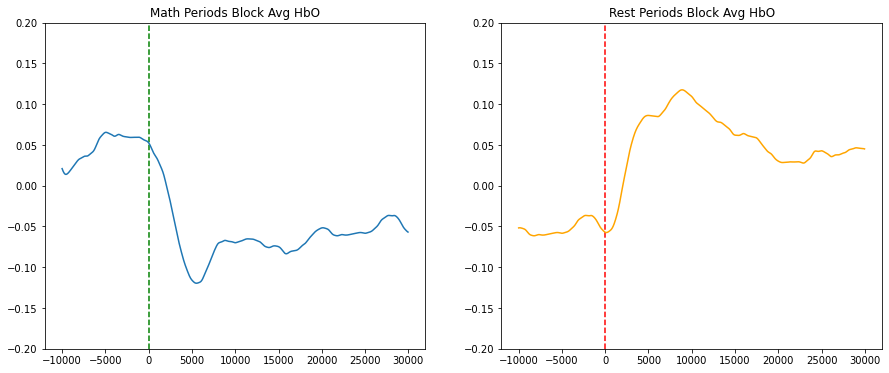

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))

ax[0].plot(math_trials[0]['timestamp'], math_hbo_avg)
ax[0].set_title("Math Periods Block Avg HbO")
ax[0].set_ylim([-0.2, 0.2])
ax[0].vlines([0], -0.2, 0.2, linestyles='dashed', colors='green')

ax[1].plot(rest_trials[0]['timestamp'], rest_hbo_avg, color='orange')
ax[1].set_title("Rest Periods Block Avg HbO")
ax[1].set_ylim([-0.2, 0.2])
ax[1].vlines([0], -0.2, 0.2, linestyles='dashed', colors='red')

In [ ]:

def get_features(df):
  feat = []

  win0 = df[(df.timestamp >= -10000) & (df.timestamp < 0)]
  win1 = df[(df.timestamp >= 0) & (df.timestamp < 10000)]
  win2 = df[(df.timestamp >= 10000) & (df.timestamp < 20000)]
  win3 = df[(df.timestamp >= 20000) & (df.timestamp < 30000)]

  feat.append(win0.hbo_filt.mean())
  feat.append(win1.hbo_filt.mean())
  feat.append(win2.hbo_filt.mean())
  feat.append(win3.hbo_filt.mean())

  feat.append(win0.hbo_filt.max())
  feat.append(win1.hbo_filt.max())
  feat.append(win2.hbo_filt.max())
  feat.append(win3.hbo_filt.max())

  feat.append(win0.hbo_filt.min())
  feat.append(win1.hbo_filt.min())
  feat.append(win2.hbo_filt.min())
  feat.append(win3.hbo_filt.min())
  
  feat.append(win0.hbo_filt.std())
  feat.append(win1.hbo_filt.std())
  feat.append(win2.hbo_filt.std())
  feat.append(win3.hbo_filt.std())

  feat.append(linregress(win0.index.values, win0.hbo_filt.values)[0])
  feat.append(linregress(win1.index.values, win1.hbo_filt.values)[0])
  feat.append(linregress(win2.index.values, win2.hbo_filt.values)[0])
  feat.append(linregress(win3.index.values, win3.hbo_filt.values)[0])

  return feat


labels = [1,0] * len(math_trials)
cols = ['mean0','mean1','mean2','mean3', 'max0','max1','max2','max3', 'min0','min1','min2','min3', 'std0','std1','std2','std3', 'slope0','slope1','slope2','slope3']
feat_df = pd.DataFrame(columns=cols)

for t in range(len(math_trials)):
  feat_df.loc[2*t] = get_features(math_trials[t])
  feat_df.loc[2*t+1] = get_features(rest_trials[t])

In [ ]:
def get_features(df):
  feat0 = []
  feat1 = []
  feat2 = []
  feat3 = []
  feat4 = []
  feat5 = []

  win0 = df[(df.timestamp >= -5000) & (df.timestamp < 5000)]
  win1 = df[(df.timestamp >= 0)     & (df.timestamp < 10000)]
  win2 = df[(df.timestamp >= 5000)  & (df.timestamp < 15000)]
  win3 = df[(df.timestamp >= 10000) & (df.timestamp < 20000)]
  win4 = df[(df.timestamp >= 15000) & (df.timestamp < 25000)]
  win5 = df[(df.timestamp >= 20000) & (df.timestamp < 30000)]


  feat0.append(win0.hbo_filt.mean())
  feat1.append(win1.hbo_filt.mean())
  feat2.append(win2.hbo_filt.mean())
  feat3.append(win3.hbo_filt.mean())
  feat4.append(win4.hbo_filt.mean())
  feat5.append(win5.hbo_filt.mean())

  feat0.append(win0.hbo_filt.max())
  feat1.append(win1.hbo_filt.max())
  feat2.append(win2.hbo_filt.max())
  feat3.append(win3.hbo_filt.max())
  feat4.append(win4.hbo_filt.max())
  feat5.append(win5.hbo_filt.max())

  feat0.append(win0.hbo_filt.min())
  feat1.append(win1.hbo_filt.min())
  feat2.append(win2.hbo_filt.min())
  feat3.append(win3.hbo_filt.min())
  feat4.append(win4.hbo_filt.min())
  feat5.append(win5.hbo_filt.min())

  feat0.append(win0.hbo_filt.std())
  feat1.append(win1.hbo_filt.std())
  feat2.append(win2.hbo_filt.std())
  feat3.append(win3.hbo_filt.std())
  feat4.append(win4.hbo_filt.std())
  feat5.append(win5.hbo_filt.std())

  feat0.append(linregress(win0.index.values, win0.hbo_filt.values)[0])
  feat1.append(linregress(win1.index.values, win1.hbo_filt.values)[0])
  feat2.append(linregress(win2.index.values, win2.hbo_filt.values)[0])
  feat3.append(linregress(win3.index.values, win3.hbo_filt.values)[0])
  feat4.append(linregress(win4.index.values, win4.hbo_filt.values)[0])
  feat5.append(linregress(win5.index.values, win5.hbo_filt.values)[0])

  return feat0, feat1, feat2, feat3, feat4, feat5


labels = []
cols = ['mean','max','min','std','slope']
feat_df = pd.DataFrame(columns=cols)

for t in range(len(rest_trials)):
  labels.append(1)
  labels.append(0)
  # labels.append(0)
  # labels.append(0)
  # labels.append(0)
  # labels.append(0)

  f0, f1, f2, f3, f4, f5 = get_features(math_trials[t])
  # f0.append(1)
  # f1.append(0)

  f6, f7, f8, f9, f10, f11 = get_features(rest_trials[t])
  # f0.append(1)
  # f1.append(0)

  feat_df.loc[2*t] = f6
  feat_df.loc[2*t+1] = random.choice([f1,f2,f3,f4,f5,f0,f7,f8,f9,f10,f11])
  # feat_df.loc[6*t+2] = feat2
  # feat_df.loc[6*t+3] = feat3
  # feat_df.loc[6*t+4] = feat4
  # feat_df.loc[6*t+5] = feat5

display(feat_df)

mean       max       min       std     slope
0    0.090309  0.156246  0.004997  0.040695  0.000042
1   -0.011852  0.156246 -0.199677  0.107452  0.000619
2    0.055969  0.217534 -0.064665  0.079553  0.000396
3    0.171177  0.334707  0.021689  0.097780  0.000472
4    0.069134  0.328865 -0.140062  0.155221  0.000610
..        ...       ...       ...       ...       ...
415 -0.117352  0.042376 -0.548918  0.146852 -0.000630
416 -0.072047  0.207032 -0.242953  0.132856 -0.000088
417 -0.034120  0.251967 -0.359476  0.191024 -0.001230
418  0.100765  0.575775 -0.138273  0.247408  0.001610
419 -0.089288  0.178163 -0.426101  0.170633  0.000245

[420 rows x 5 columns]

In [ ]:
# scaler = StandardScaler().fit(feat_df)
# X = scaler.transform(feat_df)

clf = SVC(kernel='linear', gamma='auto', C=1)

scores = cross_val_score(clf, feat_df, labels, cv=10, scoring='accuracy')
print("10-fold cross validation accuracy: ", np.mean(scores))

X_train, X_test, y_train, y_test = train_test_split(feat_df, labels, test_size=0.3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
# svm_predictions = svm_model_linear.predict(X_test)

# model accuracy for X_test  
# accuracy = svm_model_linear.score(X_test, y_test)

# creating a confusion matrix
# cm = confusion_matrix(y_test, svm_predictions)

10-fold cross validation accuracy:  0.5095238095238096
[[60  0]
 [66  0]]
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        60
           1       0.00      0.00      0.00        66

    accuracy                           0.48       126
   macro avg       0.24      0.50      0.32       126
weighted avg       0.23      0.48      0.31       126



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(feat_df, labels, test_size=0.3)
# classifier.fit(X_train_scaled, y_train)
# y_pred = classifier.predict(X_test_scaled)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))


# def f_importances(coef, names):
#     imp = coef
#     imp,names = zip(*sorted(zip(imp,names)))
#     print(imp[0])
#     plt.barh(range(len(names)), imp[0], align='center')
#     plt.yticks(range(len(names)), names)
#     plt.show()


# f_importances(classifier.coef_, cols)
# plt.axvspan(240000, 270000, color='green', alpha=0.2)
